### REINFORCE

Increase the winning probabilities and decrease the losing probabilities using the Expeted U gradient ascent function.

theta = theata plus grad-theta(Exp U)

Expected U = 1/m Sigma(1 to m) Sigma(1 to H) (Derivative w.r.t. theta of log prob (at/st) times expected reward)

In [1]:
## Libraries

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque
import gym
import matplotlib.pyplot as plt



In [2]:
torch.manual_seed(0)

import torch.optim as optim
from torch.distributions import Categorical

In [24]:
env = gym.make("CartPole-v0")
env.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    
    def __init__(self, s_size = 4, h_size = 16, a_size = 2):
        super(Policy, self).__init__()
        self.s_size = s_size
        self.h_size = h_size
        self.a_size = a_size
            
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size,a_size)
            
    def forward(self,x):
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim = 1) # final tensor must be (1,2)
    
    def act(self, state):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # state going in is (1,4) depends on how torch takes inputs
        
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
            
        


In [25]:
policy = Policy().to(device)
adam = optim.Adam(policy.parameters(), lr = 1e-2)

In [30]:
def reinforce(n_episodes = 2000, max_t = 1000, gamma = 1, print_every = 100):
    
    
    scores_deque = deque(maxlen = 100)
    scores = []
    
    for i_episode in range(1,n_episodes+1):
        
        state = env.reset()
        rewards = []
        saved_log_probs = []
        for t in range(max_t):
            
            action,log_prob = policy.act(state)
            state, reward, done,_ = env.step(action)
            rewards.append(reward) # here reward is an array 
            saved_log_probs.append(log_prob)
            if done:
                break
        scores_deque.append(sum(rewards)) #here reward is an array so can be summed like an array
        scores.append(sum(rewards))        # no need for tensor operations
        
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        expected_U = []  # python list
        for log_prob in saved_log_probs:  #  bcs we want to multiply each log_prob with -1 , R then append
                                           # reason for not just using saved_log_probs
            expected_U.append(-log_prob * R)  # log_prob is a tensor, so tensor operations must be done for concatenation
        expected_U = torch.cat(expected_U).sum()  # cat to concatenate tensors in a python sequence
        ## expectd_u is also a tensor
        
        adam.zero_grad()
        expected_U.backward()
        adam.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
        
    
    
    
    

In [31]:
scores = reinforce()

Episode 100	Average Score: 55.52
Episode 200	Average Score: 142.94
Episode 300	Average Score: 76.18
Episode 400	Average Score: 139.04
Episode 500	Average Score: 140.09
Episode 600	Average Score: 136.88
Environment solved in 585 episodes!	Average Score: 195.21


Text(0,0.5,'Scores')

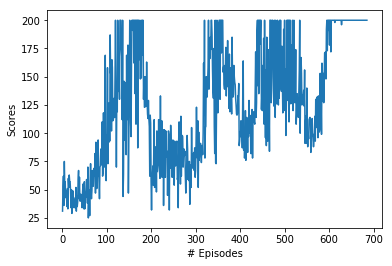

In [35]:
fig = plt.figure()

ax = fig.add_subplot(111)
plt.plot(range(1,len(scores)+1), scores)
plt.xlabel("# Episodes")
plt.ylabel("Scores")